In [1]:
import numpy  as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

import keras
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K

import matplotlib.pyplot as plt

from pickle import load

import time
import scipy

In [2]:
TAG = '38520208'    # same as the seed you set for generation

scalerFile = "scaler_%s.pkl" %TAG

N_params_mdl = 5

In [3]:
scaler = load(open(scalerFile, 'rb'))

In [4]:
N_hiddenLayers = 4
N_nodes = 64
i = keras.layers.Input(shape=(N_params_mdl+1+1, ))
x = keras.layers.Dense(N_nodes, activation='swish')(i)
c = 0
while c < N_hiddenLayers:
    x = keras.layers.Dense(N_nodes, activation='swish')(x)
    c += 1
x = keras.layers.Dense(1, activation='linear')(x)

model = keras.models.Model(inputs=i, outputs=x)

In [5]:
model.load_weights('Heston_NNWeights_pntwise_.h5')

NNWeights = []
for i in range(1, len(model.layers)):
    NNWeights.append(model.layers[i].get_weights())

### Neural Network and derivatives using numpy

In [6]:
N_layers = N_hiddenLayers + 1

def swish(x):
    return x/(np.exp(-x)+1)

def swishPrime(x):
    return (np.exp(-x)+1+x*np.exp(-x))/((np.exp(-x)+1)**2)

def NNFun(params, T, K):
    N = len(T)
    PARAMS = np.array(N*[params])
    input1 = np.c_[PARAMS, T, K] 
    for i in range(N_layers):
        input1 = np.dot(input1, NNWeights[i][0]) + NNWeights[i][1]
        input1 = swish(input1)
    i += 1
    X = np.dot(input1, NNWeights[i][0]) + NNWeights[i][1]
    X = [el[0] for el in X]
    X = np.array(X)
    return X

def NNGrad(params, T, K):
    N = len(T)
    PARAMS = np.array(N*[params])
    input1 = np.c_[PARAMS, T, K] 
    # k = 0
    input1 = np.dot(input1, NNWeights[0][0]) + NNWeights[0][1]
    grad = np.ndarray(shape=(N, N_params_mdl+1+1, N_nodes))
    for j in range(N):
        grad[j] = NNWeights[0][0]
    sP = swishPrime(input1)
    grad *= sP[:, None, :]
    input1 = swish(input1)
    #
    for k in range(1,N_layers):
        input1 = np.dot(input1, NNWeights[k][0])
        input1 += NNWeights[k][1]
        for n in range(N):
            grad[n] = np.dot(grad[n], NNWeights[k][0])
        sP = swishPrime(input1)
        grad *= sP[:, None, :]
        input1 = swish(input1)
    grad = np.dot(grad, NNWeights[k+1][0])
    grad = grad[:,:N_params_mdl].reshape(N, N_params_mdl).T
    return grad

### Market Calibration Data

In [9]:
mktData = pd.read_csv('fictitious_mktData.csv')
mktData

,T,K,imp_vol
0,0.15,0.806351,0.298422
1,0.15,0.822658,0.285506
2,0.15,0.838965,0.272368
3,0.15,0.855273,0.258959
4,0.15,0.871580,0.245243
...,...,...,...
155,2.00,0.921433,0.135054
156,2.00,1.047140,0.098306
157,2.00,1.172848,0.094581
158,2.00,1.298556,0.106119


In [10]:
maturities = mktData["T"].values
strikes = mktData["K"].values
mkt_vol = mktData["imp_vol"].values

In [11]:
T = []
for maturity in maturities:
    T.append(scaler.transform([N_params_mdl*[0] + [maturity] + [0]])[0][N_params_mdl])

K = []
for strike in strikes:
    K.append(scaler.transform([N_params_mdl*[0] + [0] + [strike]])[0][N_params_mdl+1])

### write cost Function and derivatives

In [12]:
def CostFunc(params, T, K, target):
    return np.sum(np.power((NNFun(params, T, K)-target), 2))
def Jacobian(params, T, K, target):
    return 2*np.sum((NNFun(params, T, K)-target)*NNGrad(params, T, K), axis=1)

### Define bounds for the calibration optimization

In [14]:
bounds = (scaler.transform([[2.00, 0.01, 1.00, 0.01, -0.90, 0.0, 0.0]])[0][:N_params_mdl], 
          scaler.transform([[6.00, 0.20, 2.50, 0.20, -0.50, 0.0, 0.0]])[0][:N_params_mdl])
bounds = [(lower, upper) for lower, upper in zip(*bounds)]

init = []
for bound in bounds:
    init.append(0.5*(bound[0]+bound[1]))

In [15]:
init

[0.00029767283878190387,
 -0.0008395342221633184,
 -0.00019106336034124816,
 -0.000944784300736301,
 -0.0014331056121930086]

In [16]:
start = time.time()        
res = scipy.optimize.minimize(lambda x: CostFunc(x, T, K, mkt_vol), x0=init, 
                              method='L-BFGS-B', jac=lambda x: Jacobian(x, T, K, mkt_vol), bounds=bounds, 
                              tol=1E-10, options={"maxiter":5000})
stop = time.time()

print('elapsed: ' + str(stop-start))

optm_params = scaler.inverse_transform([res.x.tolist() + [0,0]])[0][:N_params_mdl]
print('optm params: ' + str(optm_params))
fval = res.fun
print('fval: ' + str(fval))

elapsed: 0.4687535762786865
optm params: [ 4.55005019  0.02642938  1.87688898  0.02418029 -0.64561762]
fval: 0.00970572946082321


### Compute Implyed vol for the optimal params res.x

In [17]:
ivol_NN = NNFun(res.x, T, K)

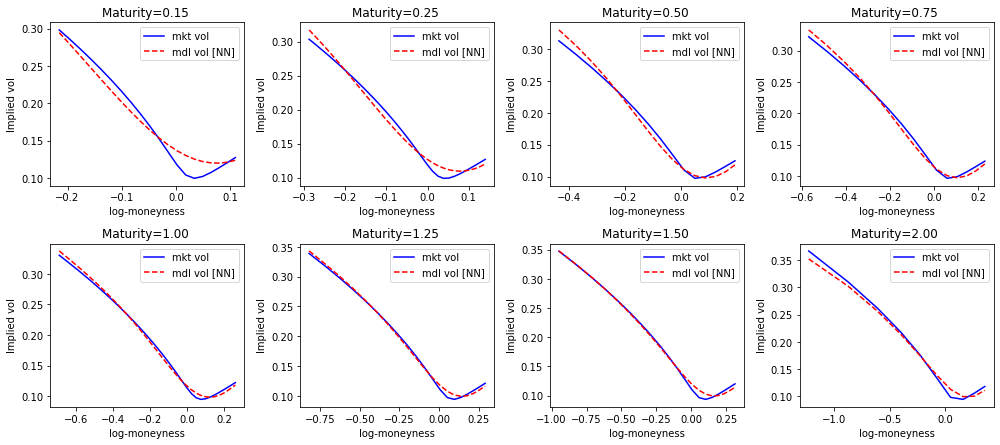

In [18]:
spot = 1.

ttm, ttm_count = np.unique(T, return_counts=True)
ttm_count_cumsum = np.cumsum(ttm_count)
ttm_count_cumsum  = np.insert(ttm_count_cumsum, 0, 0)

plt.figure(1, figsize=(14,12))
for i in range(8):
    plt.subplot(4, 4, i+1)
    
    plt.plot(np.log(np.array(strikes[ttm_count_cumsum[i]:ttm_count_cumsum[i+1]])/spot), 
             mkt_vol[ttm_count_cumsum[i]:ttm_count_cumsum[i+1]], 'b'  , label="mkt vol")
    plt.plot(np.log(np.array(strikes[ttm_count_cumsum[i]:ttm_count_cumsum[i+1]])/spot), 
             ivol_NN[ttm_count_cumsum[i]:ttm_count_cumsum[i+1]], '--r', label="mdl vol [NN]" )
    
    plt.title("Maturity=%1.2f "%np.unique(maturities)[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()
plt.tight_layout()
plt.show()